# Open Alex Extraction and Matching with .search()

The goal of this Notebook is look up the PhD students (Authors) contained in the [cleaned](clean_data.ipynb) NARCIS dataset, and
1. Confirm they can be found in OpenAlex
2. Confirm their affiliation in NARCIS matches the one in OpenAlex
2. Confirm they wrote the associated PhD Thesis
3. Per author, look up all the contributors (i.e. potential first supervisors) that are listen in the NARCIS dataset and
    a. Find all authors that have worked for the same organization at the time the PhD thesis was published (within a 1 year window)
    b. xxx


The previous version of this notebook written by a Bachelor student was using the `.search_filter()` method of `pyalex`, which does not search alternate spellings of the specified name. In this notebook we are using `search_filter()`, which does not have that problem. See the example code [here](search_parameter_vs_search_filter.ipynb).

## 1. Setup

In [10]:
#from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders, Concepts
from pyalex import config # to set email_address
import pandas as pd
from sentence_transformers import SentenceTransformer
from os import path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.unabbreviate_institutions import unabbreviate_institutions
from src.open_alex_helpers import AuthorRelations, find_phd_and_supervisors_in_row, get_supervisors_openalex_ids
from src.dataset_config_helpers import read_config, load_dataset
from src.api_cache_helpers import initialize_request_cache

# Initialize tqdm for progress bars
tqdm.pandas()

# Install the cache before any API calls are made.
# This will cache every API call to Open Alex and if a cached version of the call is available,
# it will be preferred over making a new API call.
initialize_request_cache()

Notebook settings

In [11]:
# Automatically reloads any modules that are imported, 
# so that any changes made to the module files are reflected # without needing to restart the Jupyter kernel.
# load autoreload module
%load_ext autoreload
# mode 1 reloads only when an import statement is called. For production
# mode 2 reloads before execution of every cell
%autoreload 2

# limit the number of rows that are shown with printing data frames
pd.set_option('display.max_rows', 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set contact email address to get to use the [polite pool](https://docs.openalex.org/how-to-use-the-api/rate-limits-and-authentication#the-polite-pool). Also, if you are on a premium plan, you can access the higher usage limit by using the associated email address.

In [12]:
# Get contact email address from file
email_file_path = 'contact_email.txt'

if path.isfile(email_file_path):
    with open(email_file_path, 'r') as file:
        email_address = file.read().strip()

    # Assign the email address to the pyalex configuration
    config.email = email_address

config.email

'T.L.Haven@tilburguniversity.edu'

Configure number of retries and backoff factor
Pyalex is using [urllib3.util.Retry](https://urllib3.readthedocs.io/en/stable/reference/urllib3.util.html) for retrying.

In [13]:
config.max_retries = 7
config.retry_backoff_factor = 2 # conservative backoff

## 2. Load datasets

### 2.1 Cleaned processed NARCIS dataset

In [ ]:
dataset_path = 'data/cleaned/pubs_with_domain.csv'
output_filename = 'data/output/author_relations.csv'

config = read_config('dataset_config.yaml')

pubs_df = load_dataset(config, dataset_path)

pubs_df

Reading configuration from dataset_config.yaml...


c:\Users\skirsch\surfdrive - Stefan Kirsch@surfdrive.surf.nl\Projects\MTO\PhD-supervisors\clean-and-enrich-phd-supervisor-data\src\dataset_config_helpers.py:35: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


Dataset loaded. Total rows: 94074
Using domain=None, chunk=0, nrows=10
No subsetting per domain...
Splitting DataFrame into chunks, then selecting batch #0...
Selected chunk index: 0. Rows in this chunk: 10


,integer_id,thesis_identifier,institution,domain,phd_name,title,year,language,contributor_1,contributor_2,contributor_3,contributor_4,contributor_5,contributor_6,contributor_7,contributor_8,contributor_9,contributor_10
0,1,https://pure.amc.nl/en/publications/structure-...,amcpub,NaN,"Azaripour, Adriano",Structure and function of the human periodonti...,2016,en,"van Noorden, Cornelis J. F.","Willershausen, B.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,https://pure.amc.nl/en/publications/neurocogni...,amcpub,NaN,"Thissen, Andrieke J. A. M.",Neurocognitive and genetic factors in ADHD acr...,2014,en,"Buitelaar, J. K.","Franke, B.","Lambregts-Rommelse, N. N. J.",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9,https://pure.amc.nl/en/publications/evaluation...,amcpub,NaN,"Eminović, Nina","Evaluation of telemedicine triage services, wi...",2008,en,"Hasman, Arie","Bindels, Patrick J. E.","de Keizer, Nicolette F.","Wyatt, J. C.","Witkamp, L.",NaN,NaN,NaN,NaN,NaN
9,10,https://pure.amc.nl/en/publications/hiv-screen...,amcpub,NaN,"Mugo, Peter M.",HIV screening at health facilities and communi...,2017,en,"Rinke de Wit, Tobias F.","Sanders, E. J.","Graham, S. M.",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# replace institution abbreviation with names that can be found in OpenAlex
pubs_unabbrev_df = unabbreviate_institutions(pubs_df, 'institution')
pubs_unabbrev_df


,integer_id,thesis_identifier,institution,domain,phd_name,title,year,language,contributor_1,contributor_2,contributor_3,contributor_4,contributor_5,contributor_6,contributor_7,contributor_8,contributor_9,contributor_10
0,1,https://pure.amc.nl/en/publications/structure-...,Academic Medical Center,NaN,"Azaripour, Adriano",Structure and function of the human periodonti...,2016,en,"van Noorden, Cornelis J. F.","Willershausen, B.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,https://pure.amc.nl/en/publications/neurocogni...,Academic Medical Center,NaN,"Thissen, Andrieke J. A. M.",Neurocognitive and genetic factors in ADHD acr...,2014,en,"Buitelaar, J. K.","Franke, B.","Lambregts-Rommelse, N. N. J.",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9,https://pure.amc.nl/en/publications/evaluation...,Academic Medical Center,NaN,"Eminović, Nina","Evaluation of telemedicine triage services, wi...",2008,en,"Hasman, Arie","Bindels, Patrick J. E.","de Keizer, Nicolette F.","Wyatt, J. C.","Witkamp, L.",NaN,NaN,NaN,NaN,NaN
9,10,https://pure.amc.nl/en/publications/hiv-screen...,Academic Medical Center,NaN,"Mugo, Peter M.",HIV screening at health facilities and communi...,2017,en,"Rinke de Wit, Tobias F.","Sanders, E. J.","Graham, S. M.",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2 Priority supervisor list from ResponsibleSupervision pilot

This dataset was created during the Responsible Supervision pilot project, see [here](https://github.com/tamarinde/ResponsibleSupervision/tree/main/Pilot-responsible-supervision).

In [16]:
repo_url = "https://github.com/tamarinde/ResponsibleSupervision/tree/main/Pilot-responsible-supervision/data/spreadsheets"
csv_path = "data/output/sups_pilot.csv"

try:
    # Attempt to read the supervisors in the pilot dataset from csv_path
    # If it fails, we get them again from GitHub
    supervisors_in_pilot_dataset = get_supervisors_openalex_ids(repo_url, csv_path)
    print("Unique Supervisors with OpenAlex IDs:")
    print(supervisors_in_pilot_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

Loading supervisor data from data/output/sups_pilot.csv...
Unique Supervisors with OpenAlex IDs:
{'Yijin Ren': 'https://openalex.org/A5107370167', 'Yiwei Ren': 'https://openalex.org/A5108417950', 'Rob J. M. Groen': 'https://openalex.org/A5001172956', 'Daan J. Touw': 'https://openalex.org/A5018163150', 'J Daan Touw': 'https://openalex.org/A5111280266', 'Stefan Both': 'https://openalex.org/A5106872047', 'Med Stefan Both': 'https://openalex.org/A5104048611', 'Barbara Horváth': 'https://openalex.org/A5102237723', 'Barbara M. Horvath': 'https://openalex.org/A5112484929', 'Barbara Vörös-Horváth': 'https://openalex.org/A5082982779', 'Barbara Horvath-Mechtler': 'https://openalex.org/A5000821148', 'Barbara Horvath‐Mechtler': 'https://openalex.org/A5106472164', 'Katalin Barbara Horváth': 'https://openalex.org/A5062989725', 'Barbara S. Horvath': 'https://openalex.org/A5044707822', 'Bárbara de Oliveira Horvath Pereira': 'https://openalex.org/A5002637389', 'Hanselmann Barbara': 'https://openalex.or

## 3. Extraction

Load the pre-trained SPECTER model by allenai (designed for scientific documents). We pre-load the model here, so that we don't need to do that per class instance.

Citation information can be found here: https://github.com/allenai/specter

In [17]:
model = SentenceTransformer("allenai-specter")

In [18]:
# set the dict to overwrite the default class attribute specified in src/open_alex_helpers.py
AuthorRelations.supervisors_in_pilot_dataset = supervisors_in_pilot_dataset

# Apply the function to each row with a constant, preloaded model
extraction_series = pubs_unabbrev_df.progress_apply(
    lambda row: find_phd_and_supervisors_in_row(row, model),
    axis=1
    )

# Concatenate all DataFrames into one
extraction_df = pd.concat(list(extraction_series), ignore_index=True)

extraction_df.to_csv(output_filename, index=False)

extraction_df

  0%|          | 0/10 [00:00<?, ?it/s]

,phd_name,phd_id,n_name_search_matches,year,title,title_open_alex,title_similarities,max_title_similarity,n_close_matches,exact_match,...,contributor_name,contributor_id,sup_match_by,contributor_rank,same_grad_inst,n_shared_inst_grad,is_sup_in_pilot_dataset,n_shared_pubs,shared_pubs,is_thesis_coauthor
0,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,[Cornelis J.F. Van Noorden],[https://openalex.org/A5085918635],"Name match, shared institution at graduation a...",1,True,2,False,2,"[https://doi.org/10.1186/s12903-015-0060-4, ht...",False
1,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,"[B Willershausen, Brita Willershausen]","[https://openalex.org/A5083745226, https://ope...","Name match, shared institution at graduation a...",2,False,5,False,5,"[https://doi.org/10.1111/jcpe.12627, https://d...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,"[Eduard J. Sanders, E. J. Sanders]","[https://openalex.org/A5042030913, https://ope...","Name match, shared institution at graduation a...",2,False,1,False,2,"[https://doi.org/10.1371/journal.pone.0033103,...",False
20,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,[Susan M. Graham],[https://openalex.org/A5063617127],"Name match, shared institution at graduation a...",3,False,1,False,1,[https://doi.org/10.1371/journal.pone.0170868],False


## 4. Analysis and Visualization

In [19]:
print(f"We managed to find contributors with {extraction_df['n_shared_inst_grad'].sum()} shared institutions and {extraction_df['n_shared_pubs'].sum()} shared publications!")

We managed to find contributors with 39 shared institutions and 21 shared publications!


Load the extraction dataset from file in case we didn't run the extraction

In [20]:
if 'extraction_df' not in locals() and 'extraction_df' not in globals():
    file_path = output_filename
    
    # Check if the file exists
    if path.exists(file_path):
        extraction_df = pd.read_csv(file_path)
        print(f"Read `extraction_df` from {file_path}")
    else:
        raise FileNotFoundError(f"File not found: {file_path}")
    
extraction_df

,phd_name,phd_id,n_name_search_matches,year,title,title_open_alex,title_similarities,max_title_similarity,n_close_matches,exact_match,...,contributor_name,contributor_id,sup_match_by,contributor_rank,same_grad_inst,n_shared_inst_grad,is_sup_in_pilot_dataset,n_shared_pubs,shared_pubs,is_thesis_coauthor
0,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,[Cornelis J.F. Van Noorden],[https://openalex.org/A5085918635],"Name match, shared institution at graduation a...",1,True,2,False,2,"[https://doi.org/10.1186/s12903-015-0060-4, ht...",False
1,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,"[B Willershausen, Brita Willershausen]","[https://openalex.org/A5083745226, https://ope...","Name match, shared institution at graduation a...",2,False,5,False,5,"[https://doi.org/10.1111/jcpe.12627, https://d...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,"[Eduard J. Sanders, E. J. Sanders]","[https://openalex.org/A5042030913, https://ope...","Name match, shared institution at graduation a...",2,False,1,False,2,"[https://doi.org/10.1371/journal.pone.0033103,...",False
20,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,[Susan M. Graham],[https://openalex.org/A5063617127],"Name match, shared institution at graduation a...",3,False,1,False,1,[https://doi.org/10.1371/journal.pone.0170868],False


Get PhDs that we could not find in OpenAlex.

In [21]:
# Step 1: Filter extraction_df for rows with phd_id = NaN
extraction_none_df = extraction_df.query("phd_id != phd_id")

# Step 2: Filter pubs_unabbrev_df for matching phd_names; then sort and export
pubs_phd_not_confirmed_df = (
    pubs_unabbrev_df
    .query("phd_name in @extraction_none_df.phd_name")
    .sort_values(by=["year", "institution"])   # sort by multiple columns
)

# Export to CSV without the DataFrame index
pubs_phd_not_confirmed_df.to_csv("data/output/phds_not_confirmed.csv", index=False)

pubs_phd_not_confirmed_df


,integer_id,thesis_identifier,institution,domain,phd_name,title,year,language,contributor_1,contributor_2,contributor_3,contributor_4,contributor_5,contributor_6,contributor_7,contributor_8,contributor_9,contributor_10


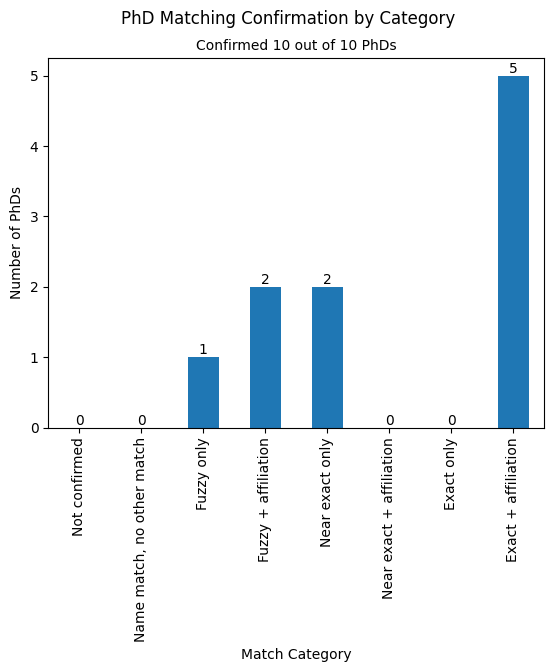

In [22]:
# Ensure one row per PhD by dropping duplicate names
count_phds_df = extraction_df[
    ['phd_name', 'phd_id', 'phd_match_by', 'phd_match_score', 'affiliation_match', 'near_exact_match', 'exact_match']
].drop_duplicates(subset='phd_name')

n_phds = len(count_phds_df)

count_phds_df['affiliation_match'] = (
    count_phds_df['affiliation_match']
    .fillna(False)
)
count_phds_df['exact_match'] = (
    count_phds_df['exact_match']
    .fillna(False)
)

# Function to assign a match category based on the flags and phd_id
def determine_category_phd(row):
    # If a PhD was found but not confirmed (i.e. no match information)
    if pd.isna(row['phd_match_by']):
        return 'Not confirmed'
    else:
        # Confirmed PhDs: split by exact and affiliation match
        if not row['phd_match_score']:
            return 'Name match, no other match'
        if not row['exact_match'] and not row['affiliation_match'] and not row['near_exact_match']:
            return 'Fuzzy only'
        elif not row['exact_match'] and row['affiliation_match'] and not row['near_exact_match']:
            return 'Fuzzy + affiliation'
        elif row['near_exact_match'] and not row['affiliation_match'] and not row['exact_match']:
            return 'Near exact only'
        elif row['near_exact_match'] and row['affiliation_match'] and not row['exact_match']:
            return 'Near exact + affiliation'
        elif row['exact_match'] and not row['affiliation_match']:
            return 'Exact only'
        elif row['exact_match'] and row['affiliation_match']:
            return 'Exact + affiliation'
        else:
            return 'Other'

# Apply the categorization function to create a new column
count_phds_df['match_category'] = count_phds_df.apply(determine_category_phd, axis=1)

bar_categories = [
    'Not confirmed',
    'Name match, no other match',
    'Fuzzy only',
    'Fuzzy + affiliation',
    'Near exact only',
    'Near exact + affiliation',
    'Exact only',
    'Exact + affiliation'
    ]
confirmed_categories = bar_categories[1:]


# Count the number of PhDs per match category
match_counts = count_phds_df['match_category'].value_counts().reindex(bar_categories)

# Calculate number of confirmed PhDs (those falling into the four confirmed categories)
n_confirmed_phds = count_phds_df['match_category'].isin(confirmed_categories).sum()

# Create a bar plot of the categories
ax = match_counts.plot(kind='bar')
ax.bar_label(ax.containers[0], label_type='edge')

# Set labels and titles for clarity
plt.xlabel("Match Category")
plt.ylabel("Number of PhDs")
plt.suptitle("PhD Matching Confirmation by Category", fontsize=12)
plt.title(f"Confirmed {n_confirmed_phds} out of {n_phds} PhDs", fontsize=10)

# Display the plot
plt.show()


In [23]:
count_phds_df

,phd_name,phd_id,phd_match_by,phd_match_score,affiliation_match,near_exact_match,exact_match,match_category
0,Adriano Azaripour,https://openalex.org/A5014282401,ranking,34,True,False,False,Fuzzy + affiliation
2,Andrieke J. A. M. Thissen,https://openalex.org/A5060058426,ranking,30,False,True,False,Near exact only
...,...,...,...,...,...,...,...,...
16,Nina Eminović,https://openalex.org/A5020260729,ranking,101,True,True,True,Exact + affiliation
19,Peter Mugo,https://openalex.org/A5046257954,ranking,7,False,False,False,Fuzzy only


In [24]:
extraction_df


,phd_name,phd_id,n_name_search_matches,year,title,title_open_alex,title_similarities,max_title_similarity,n_close_matches,exact_match,...,contributor_name,contributor_id,sup_match_by,contributor_rank,same_grad_inst,n_shared_inst_grad,is_sup_in_pilot_dataset,n_shared_pubs,shared_pubs,is_thesis_coauthor
0,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,[Cornelis J.F. Van Noorden],[https://openalex.org/A5085918635],"Name match, shared institution at graduation a...",1,True,2,False,2,"[https://doi.org/10.1186/s12903-015-0060-4, ht...",False
1,Adriano Azaripour,https://openalex.org/A5014282401,2,2016,Structure and function of the human periodonti...,(Efficacy of photodynamic therapy as adjunct t...,"(0.8810737133026123, 0.8126198053359985, 0.793...",0.881074,14,False,...,"[B Willershausen, Brita Willershausen]","[https://openalex.org/A5083745226, https://ope...","Name match, shared institution at graduation a...",2,False,5,False,5,"[https://doi.org/10.1111/jcpe.12627, https://d...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,"[Eduard J. Sanders, E. J. Sanders]","[https://openalex.org/A5042030913, https://ope...","Name match, shared institution at graduation a...",2,False,1,False,2,"[https://doi.org/10.1371/journal.pone.0033103,...",False
20,Peter Mugo,https://openalex.org/A5046257954,4,2017,HIV screening at health facilities and communi...,"(Effect of Text Message, Phone Call, and In-Pe...","(0.7744095921516418, 0.7598526477813721, 0.753...",0.774410,7,False,...,[Susan M. Graham],[https://openalex.org/A5063617127],"Name match, shared institution at graduation a...",3,False,1,False,1,[https://doi.org/10.1371/journal.pone.0170868],False


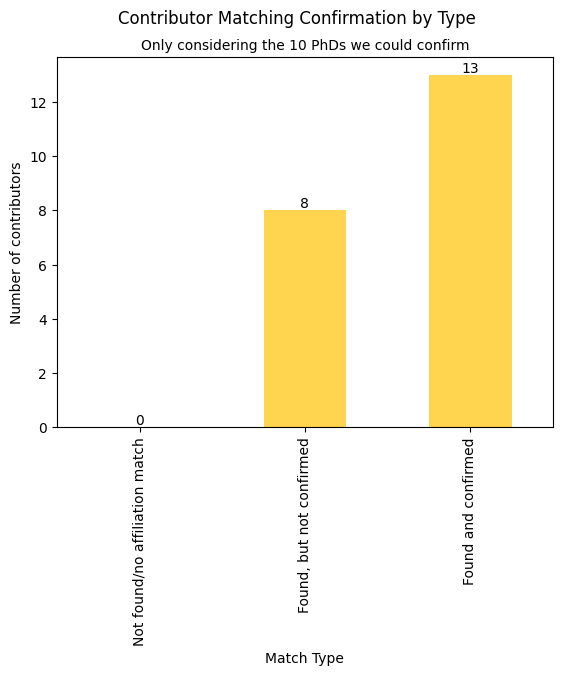

In [25]:
# Function to assign a match category based on the flags
def determine_category_contrib(row):
    # If a contributor was found but not confirmed (i.e. no match information)
    if not bool(row['contributor_id']): # returns False for None and zero length
        return 'Not found/no affiliation match'
    else:
        # Confirmed contributors
        if row['contributor_confirmed']:
            return 'Found and confirmed'
        elif not row['contributor_confirmed'] and row['contributor_id']:
            return 'Found, but not confirmed'
        else:
            return 'Other'

bar_categories = [
    #'Other',
    'Not found/no affiliation match',
    'Found, but not confirmed',
    'Found and confirmed'
]

# Apply the categorization function to create a new column
extraction_df['match_category'] = extraction_df.apply(determine_category_contrib, axis=1)

# filter out rows where 'phd_id' is Na, so that we only look at PhDs we could confirm
count_contrib_df = extraction_df.query('phd_id.notna()')[['contributor_name', 'match_category']]

# Count how many contributors per match type
match_contrib_counts = count_contrib_df['match_category'].value_counts().reindex(bar_categories)

# Create a bar plot
ax = match_contrib_counts.plot(kind='bar', color='#FFD54F')

# Add count labels on top of each bar
ax.bar_label(ax.containers[0], label_type='edge')

# Add labels and title for clarity
plt.xlabel("Match Type")
plt.ylabel("Number of contributors")
plt.suptitle("Contributor Matching Confirmation by Type", fontsize=12) # title
plt.title(f"Only considering the {n_confirmed_phds} PhDs we could confirm", fontsize=10) # subtile

# Display the plot
plt.show()